In [1]:
import os
import sys
sys.path.append('/nfs/z1/userhome/ChenXiaYu/workingdir/code/MagicBox')
import numpy as np
import nibabel as nib
import seaborn as sns
from os.path import join as pjoin
from scipy.stats import zscore
from matplotlib import pyplot as plt
from matplotlib import patches
from cxy_visual_dev.lib.predefine import proj_dir, Atlas, get_rois,\
    hemi2stru, hemi2Hemi
from magicbox.io.io import CiftiReader
from magicbox.algo.metric import calc_overlap
from magicbox.vis.plot import show_bar_value, TickRefinery

anal_dir = pjoin(proj_dir, 'analysis')
work_dir = pjoin(anal_dir, 'plot/distribution')
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

# 画主次梯度值在EDLV四个部分内的分布

## kde

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


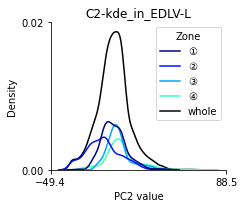

In [3]:
figsize = (3.5, 3)
pc_num = 2
Hemi = 'L'
edlv_names = ['early', 'dorsal', 'lateral', 'ventral']
edlv_name2num = {
    'early': '①', 'dorsal': '②', 'lateral': '③', 'ventral': '④'}
vis_mask = Atlas('HCP-MMP').get_mask(get_rois(f'MMP-vis3-{Hemi}'))[0]
pc_file = pjoin(
    anal_dir, 'decomposition/'
    f'HCPY-M+corrT_MMP-vis3-{Hemi}_zscore1_PCA-subj.dscalar.nii')
edlv_file = pjoin(anal_dir, 'divide_map/watershed-PC2_EDLV-seed-v1.dlabel.nii')
# edlv_file = pjoin(proj_dir, 'data/HCP/HCP-MMP1_visual-cortex3_EDLV.dlabel.nii')
out_name = f'C{pc_num}-kde_in_EDLV-{Hemi}'
out_file = pjoin(work_dir, f'{out_name}.svg')
# out_file = 'show'

pc_map = nib.load(pc_file).get_fdata()[pc_num-1, vis_mask]
pc_range = (pc_map.min(), pc_map.max())
reader = CiftiReader(edlv_file)
edlv_map = reader.get_data()[0, vis_mask]
lbl_tab = reader.label_tables()[0]
edlv_keys = np.unique(edlv_map)
edlv_num2key = {}
edlv_num2color = {}
for edlv_k in edlv_keys:
    edlv_n = lbl_tab[edlv_k].label.lstrip(f'{Hemi}_')
    if edlv_n == 'boundary':
        continue
    edlv_num = edlv_name2num[edlv_n]
    edlv_num2key[edlv_num] = edlv_k
    edlv_num2color[edlv_num] = lbl_tab[edlv_k].rgba

x_label = f'PC{pc_num} value'
data = {'Zone': [], x_label: []}
for edlv_n in edlv_names:
    edlv_num = edlv_name2num[edlv_n]
    mask = edlv_map == edlv_num2key[edlv_num]
    pc_values = pc_map[mask]
    data[x_label].extend(pc_values)
    data['Zone'].extend([edlv_num] * len(pc_values))
data[x_label] = np.r_[data[x_label], pc_map]
data['Zone'] = data['Zone'] + ['whole'] * len(pc_map)
edlv_num2color['whole'] = (0, 0, 0, 1)
fig, ax = plt.subplots(figsize=figsize)
sns.kdeplot(data=data, x=x_label, hue='Zone', palette=edlv_num2color, ax=ax)
tick_refiner = TickRefinery(ax)
tick_refiner.set_xticks_as_limit(2, 1)
tick_refiner.set_yticks_as_limit(2, 3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ymin, ymax = ax.get_ylim()
# ax.vlines(pc_range, ymin, ymax, color='k')
ax.set_title(out_name)

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)


## range proportion

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


{'early': 5.0, 'dorsal': 6.0, 'lateral': 7.0, 'ventral': 8.0, 'boundary': 10.0}
early: 0.9528945898425285; dorsal: 0.920139809978744; lateral: 0.6425871304719332; ventral: 1.08009397554295; 

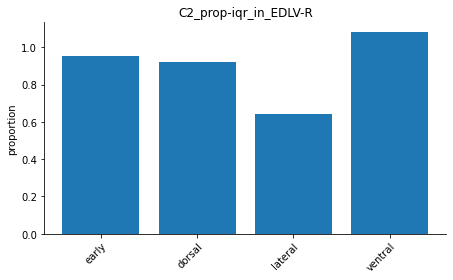

In [6]:
figsize = (6.4, 4)
range_type = 'iqr'
pc_num = 2
Hemi = 'R'
vis_name = f'MMP-vis3-{Hemi}'
edlv_names = ['early', 'dorsal', 'lateral', 'ventral']
vis_mask = Atlas('HCP-MMP').get_mask(get_rois(vis_name))[0]
pc_file = pjoin(
    anal_dir, 'decomposition/'
    f'HCPY-M+corrT_{vis_name}_zscore1_PCA-subj.dscalar.nii')
edlv_file = pjoin(anal_dir, 'divide_map/watershed-PC2_EDLV-seed-v1.dlabel.nii')
out_name = f'C{pc_num}_prop-{range_type}_in_EDLV-{Hemi}'
out_file = pjoin(work_dir, f'{out_name}.jpg')
# out_file = 'show'

def calc_range(data, range_type):
    if range_type == 'max-min':
        res = np.max(data) - np.min(data)
    elif range_type == 'iqr':
        q3, q1 = np.percentile(data, [75, 25])
        res = q3 - q1
    else:
        raise ValueError
    return res

pc_map = nib.load(pc_file).get_fdata()[pc_num-1, vis_mask]
range_all = calc_range(pc_map, range_type)
reader = CiftiReader(edlv_file)
edlv_map = reader.get_data()[0, vis_mask]
lbl_tab = reader.label_tables()[0]
edlv_keys = np.unique(edlv_map)
edlv_name2key = {}
for edlv_k in edlv_keys:
    edlv_n = lbl_tab[edlv_k].label.lstrip(f'{Hemi}_')
    edlv_name2key[edlv_n] = edlv_k
print(edlv_name2key)
x = np.arange(len(edlv_names))
y = []
for edlv_n in edlv_names:
    mask = edlv_map == edlv_name2key[edlv_n]
    range_edlv = calc_range(pc_map[mask], range_type)
    y.append(range_edlv / range_all)
    print(f'{edlv_n}: {y[-1]};', end=' ')

fig, ax = plt.subplots(figsize=figsize)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(edlv_names)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_ylabel('proportion')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(out_name)

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

## 各个局部的次梯度值的范围占总梯度轴的位置

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


RH min_all: -39.36438610561375
RH max_all: 81.0851622827645
{'early': 5.0, 'dorsal': 6.0, 'lateral': 7.0, 'ventral': 8.0, 'boundary': 10.0}


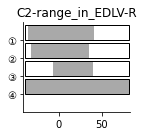

In [3]:
figsize = (2, 2)
y_step = 0.6
rect_height = 0.5
Hemi = 'R'
vis_name = f'MMP-vis3-{Hemi}'
edlv_names = ['early', 'dorsal', 'lateral', 'ventral']
edlv_name2num = {
    'early': '①', 'dorsal': '②', 'lateral': '③', 'ventral': '④'}
pc_file = pjoin(
    anal_dir, 'decomposition/'
    f'HCPY-M+corrT_{vis_name}_zscore1_PCA-subj.dscalar.nii')
edlv_file = pjoin(anal_dir, 'divide_map/watershed-PC2_EDLV-seed-v1.dlabel.nii')
out_name = f'C2-range_in_EDLV-{Hemi}'
out_file = pjoin(work_dir, f'{out_name}.svg')
out_file = 'show'

n_edlv = len(edlv_names)
vis_mask = Atlas('HCP-MMP').get_mask(get_rois(vis_name))[0]
pc_map = nib.load(pc_file).get_fdata()[1, vis_mask]
min_all, max_all = np.min(pc_map), np.max(pc_map)
print(f'{Hemi}H min_all:', min_all)
print(f'{Hemi}H max_all:', max_all)
width_all = max_all - min_all
reader = CiftiReader(edlv_file)
edlv_map = reader.get_data()[0, vis_mask]
lbl_tab = reader.label_tables()[0]
edlv_keys = np.unique(edlv_map)
edlv_name2key = {}
for edlv_k in edlv_keys:
    edlv_n = lbl_tab[edlv_k].label.lstrip(f'{Hemi}_')
    edlv_name2key[edlv_n] = edlv_k
print(edlv_name2key)
fig, ax = plt.subplots(figsize=figsize)
yticks = []
yticklabels = []
for edlv_idx, edlv_n in enumerate(edlv_names[::-1], 1):
    y = edlv_idx * y_step
    yticks.append(y)
    yticklabels.append(edlv_name2num[edlv_n])
    mask = edlv_map == edlv_name2key[edlv_n]
    data = pc_map[mask]
    min_tmp, max_tmp = np.min(data), np.max(data)
    width_tmp = max_tmp - min_tmp
    ax.add_patch(patches.Rectangle(
        (min_tmp, y), width_tmp, rect_height,
        ec=(0, 0, 0, 0), fc='darkgray'))
    ax.add_patch(patches.Rectangle(
        (min_all, y), width_all, rect_height,
        ec='k', fc=(0, 0, 0, 0)))
ax.set_xlim(min_all-2, max_all+1)
ax.set_ylim(0, (n_edlv+1)*y_step)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(out_name)

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

## 四个局部和四个通路的重叠(bar图)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


{'???': 0.0, 'early': 5.0, 'dorsal': 6.0, 'lateral': 7.0, 'ventral': 8.0}
{'early': 1.0, 'dorsal': 2.0, 'lateral': 3.0, 'ventral': 4.0, 'boundary': 9.0}


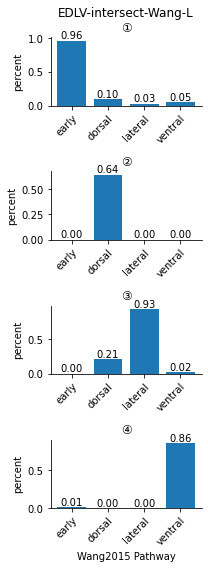

In [3]:
figsize = (3, 8)
Hemi = 'L'
vis_name = f'MMP-vis3-{Hemi}'
edlv_names = ['early', 'dorsal', 'lateral', 'ventral']
edlv2num = {'early': '①', 'dorsal': '②', 'lateral': '③', 'ventral': '④'}
vis_mask = Atlas('HCP-MMP').get_mask(get_rois(vis_name))[0]
wang_file = pjoin(proj_dir, 'data/wang2015/wang2015_4region.32k_fs_LR.dlabel.nii')
edlv_file = pjoin(anal_dir, 'divide_map/watershed-PC2_EDLV-seed-v1.dlabel.nii')
out_name = f'EDLV-intersect-Wang-{Hemi}'
out_file = pjoin(work_dir, f'{out_name}.jpg')
# out_file = 'show'

reader1 = CiftiReader(wang_file)
wang_map = reader1.get_data()[0, vis_mask]
lbl_tab1 = reader1.label_tables()[0]
wang_keys = np.unique(wang_map)
wang_name2key = {}
for wang_k in wang_keys:
    wang_n = lbl_tab1[wang_k].label.lstrip(f'{Hemi}_')
    wang_name2key[wang_n] = wang_k
print(wang_name2key)

reader2 = CiftiReader(edlv_file)
edlv_map = reader2.get_data()[0, vis_mask]
lbl_tab2 = reader2.label_tables()[0]
edlv_keys = np.unique(edlv_map)
edlv_name2key = {}
for edlv_k in edlv_keys:
    edlv_n = lbl_tab2[edlv_k].label.lstrip(f'{Hemi}_')
    edlv_name2key[edlv_n] = edlv_k
print(edlv_name2key)

n_edlv = len(edlv_names)
x = np.arange(n_edlv)
fig, axes = plt.subplots(n_edlv, 1, figsize=figsize)
for edlv_idx, edlv_n in enumerate(edlv_names):
    ax = axes[edlv_idx]
    edlv_mask = edlv_map == edlv_name2key[edlv_n]
    edlv_data = np.where(edlv_mask)[0]
    y = np.zeros(n_edlv)
    for wang_idx, wang_n in enumerate(edlv_names):
        wang_mask = wang_map == wang_name2key[wang_n]
        wang_data = np.where(wang_mask)[0]
        y[wang_idx] = calc_overlap(wang_data, edlv_data, index='percent')
    rects = ax.bar(x, y)
    show_bar_value(rects, '.2f', ax)
    ax.set_xticks(x)
    ax.set_xticklabels(edlv_names)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax.set_ylabel('percent')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if edlv_idx == 0:
        ax.set_title(f'{out_name}\n{edlv2num[edlv_n]}')
    else:
        ax.set_title(f'{edlv2num[edlv_n]}')
    if edlv_idx == n_edlv - 1:
        ax.set_xlabel('Wang2015 Pathway')

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

## 四个局部和四个通路的重叠(矩阵图)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


{'???': 0.0, 'early': 5.0, 'dorsal': 6.0, 'lateral': 7.0, 'ventral': 8.0}
{'①': 1.0, '②': 2.0, '③': 3.0, '④': 4.0}
[[8.29817833e-01 7.28667306e-02 4.79386385e-04 1.43815916e-03]
 [1.51597185e-02 1.61884136e-01 0.00000000e+00 0.00000000e+00]
 [1.01825843e-01 5.26685393e-02 5.00000000e-01 1.62921348e-01]
 [1.06060606e-01 0.00000000e+00 0.00000000e+00 2.51196172e-01]]


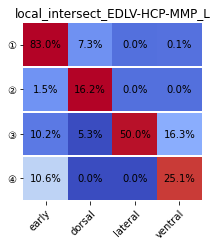

In [3]:
# 计算每个通路在每个局部内的交集占后者的百分比。
# 含义是，某个局部有多少百分比的顶点属于某个通路。
# 期望的结果是，该局部属于某个通路的百分比远大于其它通路，由此将该局部标记为该通路。
figsize = (3, 3.5)
Hemi = 'L'
vis_name = f'MMP-vis3-{Hemi}'
edlv_names = ['early', 'dorsal', 'lateral', 'ventral']
edlv2num = {'early': '①', 'dorsal': '②', 'lateral': '③', 'ventral': '④'}
edlv_type = 'HCP-MMP'
local_file = pjoin(anal_dir, 'divide_map/watershed-PC2_EDLV-seed-v1.dlabel.nii')
out_name = f'local_intersect_EDLV-{edlv_type}_{Hemi}'
out_file = pjoin(work_dir, f'{out_name}.svg')
# out_file = 'show'

edlv_type2file = {
    'Wang2015': pjoin(
        proj_dir, 'data/wang2015/wang2015_4region.32k_fs_LR.dlabel.nii'),
    'HCP-MMP': pjoin(
        proj_dir, 'data/HCP/HCP-MMP1_EDLV.dlabel.nii'),
    'HCP-MMP2': pjoin(
        proj_dir, 'data/HCP/HCP-MMP1_visual-cortex3_EDLV.dlabel.nii')}
edlv_file = edlv_type2file[edlv_type]

vis_mask = Atlas('HCP-MMP').get_mask(get_rois(vis_name))[0]
reader1 = CiftiReader(edlv_file)
edlv_map = reader1.get_data()[0, vis_mask]
lbl_tab1 = reader1.label_tables()[0]
edlv_keys = np.unique(edlv_map)
edlv_name2key = {}
for edlv_k in edlv_keys:
    edlv_n = lbl_tab1[edlv_k].label.lstrip(f'{Hemi}_')
    edlv_name2key[edlv_n] = edlv_k
print(edlv_name2key)

reader2 = CiftiReader(local_file)
local_map = reader2.get_data()[0, vis_mask]
lbl_tab2 = reader2.label_tables()[0]
local_keys = np.unique(local_map)
local_names = []
local_name2key = {}
for local_k in local_keys:
    edlv_n = lbl_tab2[local_k].label.lstrip(f'{Hemi}_')
    if edlv_n == 'boundary':
        continue
    local_n = edlv2num[edlv_n]
    local_names.append(local_n)
    local_name2key[local_n] = local_k
print(local_name2key)

n_edlv = len(edlv_names)
n_local = len(local_names)
arr = np.zeros((n_local, n_edlv))
for local_idx, local_n in enumerate(local_names):
    local_mask = local_map == local_name2key[local_n]
    local_data = np.where(local_mask)[0]
    for edlv_idx, edlv_n in enumerate(edlv_names):
        edlv_mask = edlv_map == edlv_name2key[edlv_n]
        edlv_data = np.where(edlv_mask)[0]
        arr[local_idx, edlv_idx] = \
            calc_overlap(local_data, edlv_data, index='percent')
print(arr)
arr_plot = zscore(arr, 1)
arr_show = arr * 100

fig, ax = plt.subplots(1, 1, figsize=figsize)
x = np.arange(n_edlv)
y = np.arange(n_local)
img = ax.imshow(arr_plot, 'coolwarm')
ax.set_xticks(x)
ax.set_xticklabels(edlv_names)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_yticks(y)
ax.set_yticklabels(local_names)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title(out_name)

# make grid line
grid_yticks = np.r_[y-.5, y[-1]+.5]
ax.set_yticks(grid_yticks, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
ax.tick_params(which="minor", bottom=False, left=False)

# show values
for i in range(n_local):
    for j in range(n_edlv):
        weight = None  # bold or None
        ax.text(j, i, '{:.1f}%'.format(arr_show[i, j]),
                ha="center", va="center", color="k", weight=weight)

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)